In [11]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import os
import json
import math
from pprint import pprint

In [12]:
# Load the Zip CSV
zip_csv = "./Resources/ZipCode.csv"
zip_df = pd.read_csv(zip_csv)
zip_df

,ZipCode,City,County
0,94203,Sacramento,Sacramento County
1,94204,Sacramento,Sacramento County
2,94205,Sacramento,Sacramento County
3,94206,Sacramento,Sacramento County
4,94207,Sacramento,Sacramento County
...,...,...,...
127,95853,Sacramento,Sacramento County
128,95860,Sacramento,Sacramento County
129,95864,Sacramento,Sacramento County
130,95865,Sacramento,Sacramento County


In [13]:
# Load the Crime CSV
crime_csv = "./Resources/Crime.csv"
crime_df = pd.read_csv(crime_csv)
crime_df

,X,Y,FID,ActivityNumber,District,Neighborhood,OccurenceStartDate,OccurenceEndDate,ReportDate,OccurenceLocation,OccurenceCity,OccurenceZipCode,PrimaryViolation
0,6.765513e+06,1.994405e+06,1,NaN,NaN,Old Fair Oaks,2009/03/26 17:10:00,2009/03/26 17:19:59,2009/03/26 17:39:00,9300 Block of Fair O,Fair Oaks,95628,PC 594(B)(1) Vandalism ($400 Or More)
1,1.517236e-04,-2.607703e-06,2,"]\=""-0092335",North Central,Carmichael Park,2018/03/19 21:30:00,2018/03/19 21:59:59,2018/03/20 17:00:00,5100 Block of Janell,Carmichael,95608,PC 273.5 Inflict Crpl Inj Sp/Cohab
2,6.756477e+06,1.974923e+06,3,03/30-0055028,East,Cordova Meadows,2015/03/06 01:11:00,2015/03/06 01:11:00,2015/03/06 00:00:00,10000 Block of Terra,Rancho Cordova,95670,PC 594(B)(2)(A) Vandalism Less Than $400
3,6.741558e+06,1.960069e+06,4,19-0009846,East,Rosemont Downs,2019/01/09 08:52:59,2019/01/09 09:04:00,2019/01/09 14:19:00,8900 Block of Canberra Dr,Sacramento,95826,PC 459 Burglary
4,6.749211e+06,2.004272e+06,5,1977-0020606,North,Foothill Farms NE,1977/01/01 00:00:00,2001/01/01 00:00:00,2019/08/06 00:00:00,5200 Block of Auburn Blvd,Sacramento,95841,PC 261(A)(1) Rape:Victim Incapable Of Giving C...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
362000,1.517236e-04,-2.607703e-06,362001,2020-8002056,NaN,NaN,2018/12/15 02:16:00,2019/09/23 16:18:00,2020/01/28 03:24:59,5100 Block of spyglass drive DR,las vegas nevada,NaN,PC 530.5(B) Using Another Person's Identifying...
362001,1.517236e-04,-2.607703e-06,362002,2020-8002082,NaN,NaN,2019/11/20 01:01:00,2019/11/20 23:58:59,2020/01/10 10:44:00,8300 Block of MEDEIROS WAY,SACRAMENTO,95829,PC 368(D) Theft of Elder
362002,6.755575e+06,2.005506e+06,362003,2020-8002107,North,Mercy San Juan,2020/01/21 03:00:00,2020/01/21 03:14:59,2020/01/21 10:28:00,6100 Block of Marwick Way,Carmichael,95608,PC 487 Theft from vehicle > $950
362003,6.764044e+06,1.997386e+06,362004,2-0282708,Northeast,Old Fair Oaks,2012/12/20 13:57:00,2012/12/20 13:57:00,2012/12/20 13:57:00,7400 Block of Windin,Fair Oaks,95628,PC 459 Burglary


In [14]:
# Get a list of the indexes where the OccuranceZipCode is empty or NaN
crime_zip_eq_null_index = crime_df.index[(crime_df["OccurenceZipCode"] == "") |
                                         (crime_df["OccurenceZipCode"] == " ") |
                                         (crime_df["OccurenceZipCode"] == "9560") |
                                         (crime_df["OccurenceZipCode"].isnull()) ]
crime_zip_eq_null_index

Int64Index([     9,     55,     63,     64,     70,     78,    106,    221,
               225,    376,
            ...
            360576, 360580, 360711, 361257, 361315, 361496, 361548, 361636,
            361894, 362000],
           dtype='int64', length=2611)

In [15]:
# Drop the indexes where the OccuranceZipCode is empty or NaN
preclean_crime_df = crime_df.drop(crime_zip_eq_null_index, inplace=False)
preclean_crime_df

,X,Y,FID,ActivityNumber,District,Neighborhood,OccurenceStartDate,OccurenceEndDate,ReportDate,OccurenceLocation,OccurenceCity,OccurenceZipCode,PrimaryViolation
0,6.765513e+06,1.994405e+06,1,NaN,NaN,Old Fair Oaks,2009/03/26 17:10:00,2009/03/26 17:19:59,2009/03/26 17:39:00,9300 Block of Fair O,Fair Oaks,95628,PC 594(B)(1) Vandalism ($400 Or More)
1,1.517236e-04,-2.607703e-06,2,"]\=""-0092335",North Central,Carmichael Park,2018/03/19 21:30:00,2018/03/19 21:59:59,2018/03/20 17:00:00,5100 Block of Janell,Carmichael,95608,PC 273.5 Inflict Crpl Inj Sp/Cohab
2,6.756477e+06,1.974923e+06,3,03/30-0055028,East,Cordova Meadows,2015/03/06 01:11:00,2015/03/06 01:11:00,2015/03/06 00:00:00,10000 Block of Terra,Rancho Cordova,95670,PC 594(B)(2)(A) Vandalism Less Than $400
3,6.741558e+06,1.960069e+06,4,19-0009846,East,Rosemont Downs,2019/01/09 08:52:59,2019/01/09 09:04:00,2019/01/09 14:19:00,8900 Block of Canberra Dr,Sacramento,95826,PC 459 Burglary
4,6.749211e+06,2.004272e+06,5,1977-0020606,North,Foothill Farms NE,1977/01/01 00:00:00,2001/01/01 00:00:00,2019/08/06 00:00:00,5200 Block of Auburn Blvd,Sacramento,95841,PC 261(A)(1) Rape:Victim Incapable Of Giving C...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
361999,6.772374e+06,2.000409e+06,362000,2020-8002054,North,Old Fair Oaks,2020/01/17 09:00:00,2020/01/17 15:59:59,2020/01/18 13:57:59,8100 Block of Sunset Ave,Fair Oaks,95628,PC 484G Thft:Use Access Card Data
362001,1.517236e-04,-2.607703e-06,362002,2020-8002082,NaN,NaN,2019/11/20 01:01:00,2019/11/20 23:58:59,2020/01/10 10:44:00,8300 Block of MEDEIROS WAY,SACRAMENTO,95829,PC 368(D) Theft of Elder
362002,6.755575e+06,2.005506e+06,362003,2020-8002107,North,Mercy San Juan,2020/01/21 03:00:00,2020/01/21 03:14:59,2020/01/21 10:28:00,6100 Block of Marwick Way,Carmichael,95608,PC 487 Theft from vehicle > $950
362003,6.764044e+06,1.997386e+06,362004,2-0282708,Northeast,Old Fair Oaks,2012/12/20 13:57:00,2012/12/20 13:57:00,2012/12/20 13:57:00,7400 Block of Windin,Fair Oaks,95628,PC 459 Burglary


In [16]:
# Rename OccuranceZipCode to just ZipCode
preclean_crime_df = preclean_crime_df.rename(columns={"OccurenceZipCode": "ZipCode"})
preclean_crime_df

,X,Y,FID,ActivityNumber,District,Neighborhood,OccurenceStartDate,OccurenceEndDate,ReportDate,OccurenceLocation,OccurenceCity,ZipCode,PrimaryViolation
0,6.765513e+06,1.994405e+06,1,NaN,NaN,Old Fair Oaks,2009/03/26 17:10:00,2009/03/26 17:19:59,2009/03/26 17:39:00,9300 Block of Fair O,Fair Oaks,95628,PC 594(B)(1) Vandalism ($400 Or More)
1,1.517236e-04,-2.607703e-06,2,"]\=""-0092335",North Central,Carmichael Park,2018/03/19 21:30:00,2018/03/19 21:59:59,2018/03/20 17:00:00,5100 Block of Janell,Carmichael,95608,PC 273.5 Inflict Crpl Inj Sp/Cohab
2,6.756477e+06,1.974923e+06,3,03/30-0055028,East,Cordova Meadows,2015/03/06 01:11:00,2015/03/06 01:11:00,2015/03/06 00:00:00,10000 Block of Terra,Rancho Cordova,95670,PC 594(B)(2)(A) Vandalism Less Than $400
3,6.741558e+06,1.960069e+06,4,19-0009846,East,Rosemont Downs,2019/01/09 08:52:59,2019/01/09 09:04:00,2019/01/09 14:19:00,8900 Block of Canberra Dr,Sacramento,95826,PC 459 Burglary
4,6.749211e+06,2.004272e+06,5,1977-0020606,North,Foothill Farms NE,1977/01/01 00:00:00,2001/01/01 00:00:00,2019/08/06 00:00:00,5200 Block of Auburn Blvd,Sacramento,95841,PC 261(A)(1) Rape:Victim Incapable Of Giving C...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
361999,6.772374e+06,2.000409e+06,362000,2020-8002054,North,Old Fair Oaks,2020/01/17 09:00:00,2020/01/17 15:59:59,2020/01/18 13:57:59,8100 Block of Sunset Ave,Fair Oaks,95628,PC 484G Thft:Use Access Card Data
362001,1.517236e-04,-2.607703e-06,362002,2020-8002082,NaN,NaN,2019/11/20 01:01:00,2019/11/20 23:58:59,2020/01/10 10:44:00,8300 Block of MEDEIROS WAY,SACRAMENTO,95829,PC 368(D) Theft of Elder
362002,6.755575e+06,2.005506e+06,362003,2020-8002107,North,Mercy San Juan,2020/01/21 03:00:00,2020/01/21 03:14:59,2020/01/21 10:28:00,6100 Block of Marwick Way,Carmichael,95608,PC 487 Theft from vehicle > $950
362003,6.764044e+06,1.997386e+06,362004,2-0282708,Northeast,Old Fair Oaks,2012/12/20 13:57:00,2012/12/20 13:57:00,2012/12/20 13:57:00,7400 Block of Windin,Fair Oaks,95628,PC 459 Burglary


In [17]:
# Just Grab the year from the date stamps and make a new column for it
preclean_crime_df["DateTime"] = pd.to_datetime(preclean_crime_df["OccurenceStartDate"])
preclean_crime_df["Year"] = preclean_crime_df["DateTime"].dt.year
preclean_crime_df.head()

,X,Y,FID,ActivityNumber,District,Neighborhood,OccurenceStartDate,OccurenceEndDate,ReportDate,OccurenceLocation,OccurenceCity,ZipCode,PrimaryViolation,DateTime,Year
0,6.765513e+06,1.994405e+06,1,NaN,NaN,Old Fair Oaks,2009/03/26 17:10:00,2009/03/26 17:19:59,2009/03/26 17:39:00,9300 Block of Fair O,Fair Oaks,95628,PC 594(B)(1) Vandalism ($400 Or More),2009-03-26 17:10:00,2009
1,1.517236e-04,-2.607703e-06,2,"]\=""-0092335",North Central,Carmichael Park,2018/03/19 21:30:00,2018/03/19 21:59:59,2018/03/20 17:00:00,5100 Block of Janell,Carmichael,95608,PC 273.5 Inflict Crpl Inj Sp/Cohab,2018-03-19 21:30:00,2018
2,6.756477e+06,1.974923e+06,3,03/30-0055028,East,Cordova Meadows,2015/03/06 01:11:00,2015/03/06 01:11:00,2015/03/06 00:00:00,10000 Block of Terra,Rancho Cordova,95670,PC 594(B)(2)(A) Vandalism Less Than $400,2015-03-06 01:11:00,2015
3,6.741558e+06,1.960069e+06,4,19-0009846,East,Rosemont Downs,2019/01/09 08:52:59,2019/01/09 09:04:00,2019/01/09 14:19:00,8900 Block of Canberra Dr,Sacramento,95826,PC 459 Burglary,2019-01-09 08:52:59,2019
4,6.749211e+06,2.004272e+06,5,1977-0020606,North,Foothill Farms NE,1977/01/01 00:00:00,2001/01/01 00:00:00,2019/08/06 00:00:00,5200 Block of Auburn Blvd,Sacramento,95841,PC 261(A)(1) Rape:Victim Incapable Of Giving C...,1977-01-01 00:00:00,1977


In [18]:
# Just Grab years 2014-2018
preclean_crime_years_filter = preclean_crime_df["Year"].isin([2014, 2015, 2016, 2017, 2018])
preclean_crime_years_df = preclean_crime_df[preclean_crime_years_filter]
preclean_crime_years_df

,X,Y,FID,ActivityNumber,District,Neighborhood,OccurenceStartDate,OccurenceEndDate,ReportDate,OccurenceLocation,OccurenceCity,ZipCode,PrimaryViolation,DateTime,Year
1,1.517236e-04,-2.607703e-06,2,"]\=""-0092335",North Central,Carmichael Park,2018/03/19 21:30:00,2018/03/19 21:59:59,2018/03/20 17:00:00,5100 Block of Janell,Carmichael,95608,PC 273.5 Inflict Crpl Inj Sp/Cohab,2018-03-19 21:30:00,2018
2,6.756477e+06,1.974923e+06,3,03/30-0055028,East,Cordova Meadows,2015/03/06 01:11:00,2015/03/06 01:11:00,2015/03/06 00:00:00,10000 Block of Terra,Rancho Cordova,95670,PC 594(B)(2)(A) Vandalism Less Than $400,2015-03-06 01:11:00,2015
218368,6.753071e+06,1.967571e+06,218369,2013-0289868,East,Lincoln Village,2014/01/01 12:56:00,2014/01/01 01:44:59,2014/01/01 01:44:59,Egmont Way & Viking,Sacramento,95827,VC 23152(A) Dui Alcohol/Drugs,2014-01-01 12:56:00,2014
226870,6.754609e+06,1.968828e+06,226871,2014-0000030,East,Lincoln Village,2014/01/01 00:14:59,2014/01/01 00:14:59,2014/01/01 00:42:00,3300 Block of Explor,Sacramento,95827,PC 246 Shoot At Inhabited Dwelling/Vehicle/Etc,2014-01-01 00:14:59,2014
226871,6.747809e+06,1.969023e+06,226872,2014-0000031,Elk Grove,Butterfield,2014/01/01 00:27:00,2014/01/01 00:27:00,2014/01/01 00:30:00,9300 Block of Mira D,Sacramento,95827,PC 459 Burglary,2014-01-01 00:27:00,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361571,6.765676e+06,1.971360e+06,361572,2020-8000851,Rancho Cordova,Stone Creek,2017/05/14 08:00:00,2017/05/14 21:59:59,2020/01/21 10:31:59,3500 Block of Cap Rock Way,Rancho Cordova,95670,PC 530.5(B) Using Another Person's Identifying...,2017-05-14 08:00:00,2017
361637,6.781380e+06,2.003620e+06,361638,2020-8000988,North,East Fair Oaks,2017/02/05 12:00:00,2020/01/29 12:56:59,2020/01/29 13:18:59,5200 Block of Arbardee Dr,Fair Oaks,95628,PC 653M Harassment By Telephone,2017-02-05 12:00:00,2017
361647,6.740184e+06,1.987419e+06,361648,2020-8001029,North Central,Arcade Village,2014/01/01 00:01:00,2020/01/13 00:01:00,2020/01/13 15:11:59,3800 Block of Marconi Ave,Sacramento,95821,PC 653M Harassment By Telephone,2014-01-01 00:01:00,2014
361708,1.517236e-04,-2.607703e-06,361709,2020-8001124,NaN,NaN,2015/08/03 09:10:00,2020/01/19 10:08:00,2020/01/29 09:11:59,8500 Block of Red water DR,ANTELOPE,95842,PC 530.5(B) Using Another Person's Identifying...,2015-08-03 09:10:00,2015


In [19]:
# Create a new PC column and simply have it be the PC number
preclean_crime_years_df["PC"] = preclean_crime_years_df["PrimaryViolation"]
preclean_crime_years_df["PC"] = preclean_crime_years_df["PC"].replace(r"PC (\d+(\.\d+)?).*", r"\1", regex=True)
# preclean_crime_years_df.to_csv("./Resources/Crime_preclean.csv")
preclean_crime_years_df.head()

,X,Y,FID,ActivityNumber,District,Neighborhood,OccurenceStartDate,OccurenceEndDate,ReportDate,OccurenceLocation,OccurenceCity,ZipCode,PrimaryViolation,DateTime,Year,PC
1,1.517236e-04,-2.607703e-06,2,"]\=""-0092335",North Central,Carmichael Park,2018/03/19 21:30:00,2018/03/19 21:59:59,2018/03/20 17:00:00,5100 Block of Janell,Carmichael,95608,PC 273.5 Inflict Crpl Inj Sp/Cohab,2018-03-19 21:30:00,2018,273.5
2,6.756477e+06,1.974923e+06,3,03/30-0055028,East,Cordova Meadows,2015/03/06 01:11:00,2015/03/06 01:11:00,2015/03/06 00:00:00,10000 Block of Terra,Rancho Cordova,95670,PC 594(B)(2)(A) Vandalism Less Than $400,2015-03-06 01:11:00,2015,594
218368,6.753071e+06,1.967571e+06,218369,2013-0289868,East,Lincoln Village,2014/01/01 12:56:00,2014/01/01 01:44:59,2014/01/01 01:44:59,Egmont Way & Viking,Sacramento,95827,VC 23152(A) Dui Alcohol/Drugs,2014-01-01 12:56:00,2014,VC 23152(A) Dui Alcohol/Drugs
226870,6.754609e+06,1.968828e+06,226871,2014-0000030,East,Lincoln Village,2014/01/01 00:14:59,2014/01/01 00:14:59,2014/01/01 00:42:00,3300 Block of Explor,Sacramento,95827,PC 246 Shoot At Inhabited Dwelling/Vehicle/Etc,2014-01-01 00:14:59,2014,246
226871,6.747809e+06,1.969023e+06,226872,2014-0000031,Elk Grove,Butterfield,2014/01/01 00:27:00,2014/01/01 00:27:00,2014/01/01 00:30:00,9300 Block of Mira D,Sacramento,95827,PC 459 Burglary,2014-01-01 00:27:00,2014,459


In [20]:
# Blank out the PC's we don't care about
preclean_crime_years_df["PC"] = preclean_crime_years_df["PC"].replace(r".*WI .*", r"", regex=True)
preclean_crime_years_df["PC"] = preclean_crime_years_df["PC"].replace(r".*US .*", r"", regex=True)
preclean_crime_years_df["PC"] = preclean_crime_years_df["PC"].replace(r".*SCO .*", r"", regex=True)
preclean_crime_years_df["PC"] = preclean_crime_years_df["PC"].replace(r".*SCC .*", r"", regex=True)
preclean_crime_years_df["PC"] = preclean_crime_years_df["PC"].replace(r".*RCC .*", r"", regex=True)
preclean_crime_years_df["PC"] = preclean_crime_years_df["PC"].replace(r".*PW .*", r"", regex=True)
preclean_crime_years_df["PC"] = preclean_crime_years_df["PC"].replace(r".*HS .*", r"", regex=True)
preclean_crime_years_df["PC"] = preclean_crime_years_df["PC"].replace(r".*HN .*", r"", regex=True)
preclean_crime_years_df["PC"] = preclean_crime_years_df["PC"].replace(r".*FG .*", r"", regex=True)
preclean_crime_years_df["PC"] = preclean_crime_years_df["PC"].replace(r".*EC .*", r"", regex=True)
preclean_crime_years_df["PC"] = preclean_crime_years_df["PC"].replace(r".*CAD .*", r"", regex=True)
preclean_crime_years_df["PC"] = preclean_crime_years_df["PC"].replace(r".*CA .*", r"", regex=True)
preclean_crime_years_df["PC"] = preclean_crime_years_df["PC"].replace(r".*BP .*", r"", regex=True)
preclean_crime_years_df["PC"] = preclean_crime_years_df["PC"].replace(r".*VC .*", r"", regex=True)

# Get a list of the indexes where the PC is empty or NaN
preclean_crime_pc_eq_null_index = preclean_crime_years_df.index[(preclean_crime_years_df["PC"] == "") | 
                                                                (preclean_crime_years_df["PC"].isnull()) ]

# Drop the indexes where the PC is empty or NaN
clean_crime_df = preclean_crime_years_df.drop(preclean_crime_pc_eq_null_index, inplace=False)

# Convert PC to Float
clean_crime_df["PC"] = pd.to_numeric(clean_crime_df["PC"])
clean_crime_df["PC"] = clean_crime_df["PC"].astype(float)

# Convert ZipCode to int
clean_crime_df["ZipCode"] = pd.to_numeric(clean_crime_df["ZipCode"])
clean_crime_df["ZipCode"] = clean_crime_df["ZipCode"].astype(int)

# Save the cleaned CSV
clean_crime_df.to_csv("./Resources/Crime_clean.csv", index=False)
clean_crime_df

,X,Y,FID,ActivityNumber,District,Neighborhood,OccurenceStartDate,OccurenceEndDate,ReportDate,OccurenceLocation,OccurenceCity,ZipCode,PrimaryViolation,DateTime,Year,PC
1,1.517236e-04,-2.607703e-06,2,"]\=""-0092335",North Central,Carmichael Park,2018/03/19 21:30:00,2018/03/19 21:59:59,2018/03/20 17:00:00,5100 Block of Janell,Carmichael,95608,PC 273.5 Inflict Crpl Inj Sp/Cohab,2018-03-19 21:30:00,2018,273.5
2,6.756477e+06,1.974923e+06,3,03/30-0055028,East,Cordova Meadows,2015/03/06 01:11:00,2015/03/06 01:11:00,2015/03/06 00:00:00,10000 Block of Terra,Rancho Cordova,95670,PC 594(B)(2)(A) Vandalism Less Than $400,2015-03-06 01:11:00,2015,594.0
226870,6.754609e+06,1.968828e+06,226871,2014-0000030,East,Lincoln Village,2014/01/01 00:14:59,2014/01/01 00:14:59,2014/01/01 00:42:00,3300 Block of Explor,Sacramento,95827,PC 246 Shoot At Inhabited Dwelling/Vehicle/Etc,2014-01-01 00:14:59,2014,246.0
226871,6.747809e+06,1.969023e+06,226872,2014-0000031,Elk Grove,Butterfield,2014/01/01 00:27:00,2014/01/01 00:27:00,2014/01/01 00:30:00,9300 Block of Mira D,Sacramento,95827,PC 459 Burglary,2014-01-01 00:27:00,2014,459.0
226873,6.728042e+06,1.985577e+06,226874,2014-0000033,North Central,Bellview,2014/01/01 00:24:59,2014/01/01 00:27:00,2014/01/01 00:48:00,2600 Block of Darwin,Sacramento,95821,PC 594(A) Vandalism,2014-01-01 00:24:59,2014,594.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361571,6.765676e+06,1.971360e+06,361572,2020-8000851,Rancho Cordova,Stone Creek,2017/05/14 08:00:00,2017/05/14 21:59:59,2020/01/21 10:31:59,3500 Block of Cap Rock Way,Rancho Cordova,95670,PC 530.5(B) Using Another Person's Identifying...,2017-05-14 08:00:00,2017,530.5
361637,6.781380e+06,2.003620e+06,361638,2020-8000988,North,East Fair Oaks,2017/02/05 12:00:00,2020/01/29 12:56:59,2020/01/29 13:18:59,5200 Block of Arbardee Dr,Fair Oaks,95628,PC 653M Harassment By Telephone,2017-02-05 12:00:00,2017,653.0
361647,6.740184e+06,1.987419e+06,361648,2020-8001029,North Central,Arcade Village,2014/01/01 00:01:00,2020/01/13 00:01:00,2020/01/13 15:11:59,3800 Block of Marconi Ave,Sacramento,95821,PC 653M Harassment By Telephone,2014-01-01 00:01:00,2014,653.0
361708,1.517236e-04,-2.607703e-06,361709,2020-8001124,NaN,NaN,2015/08/03 09:10:00,2020/01/19 10:08:00,2020/01/29 09:11:59,8500 Block of Red water DR,ANTELOPE,95842,PC 530.5(B) Using Another Person's Identifying...,2015-08-03 09:10:00,2015,530.5


In [22]:
clean_crime_personal_df = clean_crime_df.loc[((clean_crime_df["PC"] >= 187 ) &
                                              (clean_crime_df["PC"] <= 368.7))]
clean_crime_personal_df.to_csv("./Resources/Crime_Persons_clean.csv", index=False)
clean_crime_personal_df

,X,Y,FID,ActivityNumber,District,Neighborhood,OccurenceStartDate,OccurenceEndDate,ReportDate,OccurenceLocation,OccurenceCity,ZipCode,PrimaryViolation,DateTime,Year,PC
1,1.517236e-04,-2.607703e-06,2,"]\=""-0092335",North Central,Carmichael Park,2018/03/19 21:30:00,2018/03/19 21:59:59,2018/03/20 17:00:00,5100 Block of Janell,Carmichael,95608,PC 273.5 Inflict Crpl Inj Sp/Cohab,2018-03-19 21:30:00,2018,273.5
226870,6.754609e+06,1.968828e+06,226871,2014-0000030,East,Lincoln Village,2014/01/01 00:14:59,2014/01/01 00:14:59,2014/01/01 00:42:00,3300 Block of Explor,Sacramento,95827,PC 246 Shoot At Inhabited Dwelling/Vehicle/Etc,2014-01-01 00:14:59,2014,246.0
226874,6.716038e+06,2.011683e+06,226875,2014-0000037,Northwest,Rio Linda,2014/01/01 00:30:00,2014/01/01 00:49:59,2014/01/01 00:59:59,300 Block of Jubilee,Rio Linda,95673,PC 245(A)(1) Force/Assault With A Deadly Weapo...,2014-01-01 00:30:00,2014,245.0
226879,6.739443e+06,1.967965e+06,226880,2014-0000126,Elk Grove,La Riviera East,2014/01/01 00:45:00,2014/01/01 00:49:59,2014/01/02 03:00:00,8700 Block of La Riv,Sacramento,95826,PC 245(A)(1) Force/Assault With A Deadly Weapo...,2014-01-01 00:45:00,2014,245.0
226880,6.740270e+06,2.008541e+06,226881,2014-0000132,Northwest,North Highlands,2014/01/01 02:19:59,2014/01/01 02:29:59,2014/01/01 04:05:59,6000 Block of N Have,North Highlands,95660,PC 247(B) Shoot At Unoccupied Dwelling/Vehicle...,2014-01-01 02:19:59,2014,247.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358629,6.704436e+06,1.929633e+06,358630,2019-8010720,South,Freeport,2016/11/25 12:00:00,2019/11/25 02:13:59,2019/11/25 15:01:59,8100 Block of Freeport Blvd,Sacramento,95832,PC 368(D) Theft of Elder,2016-11-25 12:00:00,2016,368.0
358866,6.739617e+06,2.013520e+06,358867,2019-8011006,Northwest,North Highlands,2018/12/27 14:13:00,2019/07/15 00:00:00,2019/11/22 12:11:59,3800 Block of Milton Way,North Highlands,95660,PC 368(D) Theft of Elder,2018-12-27 14:13:00,2018,368.0
359333,6.719714e+06,1.941237e+06,359334,2019-8011562,Central,Parkway Estates East,2018/11/25 12:00:00,2019/08/22 12:00:00,2019/12/23 12:04:59,4800 Block of F Pkwy,Sacramento,95823,PC 368(D) Theft of Elder,2018-11-25 12:00:00,2018,368.0
360443,6.721975e+06,2.009339e+06,360444,2020-0024087,Northwest,Rio Linda,2014/01/01 00:00:00,2015/12/31 23:58:59,2020/01/21 22:54:00,6100 Block of Dry Creek Rd,Rio Linda,95673,PC 288(A) Lewd Or Lascivious Acts W/Child Unde...,2014-01-01 00:00:00,2014,288.0


In [23]:
clean_crime_personal_df.groupby("ZipCode").count()


,X,Y,FID,ActivityNumber,District,Neighborhood,OccurenceStartDate,OccurenceEndDate,ReportDate,OccurenceLocation,OccurenceCity,PrimaryViolation,DateTime,Year,PC
ZipCode,,,,,,,,,,,,,,,
32312,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1
32583,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1
43231,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1
71701,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1
83616,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95864,366,366,366,366,363,363,366,366,366,366,366,366,366,366,366
95961,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1
95964,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1


In [13]:
# clean_crime_min_df = pd.DataFrame()
# clean_crime_min_df["PC"] = clean_crime_df["PC"]
# clean_crime_min_df["Year"] = clean_crime_df["Year"]
# clean_crime_sum_group = clean_crime_min_df.groupby("Year").count()
# clean_crime_sum_group.plot(kind="bar")
# # plt.grid()
# # plt.xlim((15, 25))
# # plt.ylim((34, 46))
# plt.title("Crimes over the years 2014-2018")
# plt.xlabel("Year")
# plt.ylabel("Number of Crimes")
# plt.savefig("./Images/CrimesBar2014-2018_pyplot.png")
# plt.show()

In [14]:
# # Scatter plot of Personal Offenses across all Zip Codes
# clean_crime_personal_min_df = pd.DataFrame()
# clean_crime_personal_min_df["PC"] = clean_crime_personal_df["PC"]
# clean_crime_personal_min_df["Year"] = clean_crime_personal_df["Year"]
# clean_crime_personal_sum_group = clean_crime_personal_min_df.groupby("Year").count()
# clean_crime_personal_sum_group.plot(kind="bar")
# # plt.grid()
# # plt.xlim((15, 25))
# # plt.ylim((34, 46))
# plt.title("Personal Crimes over the years 2014-2018")
# plt.xlabel("Year")
# plt.ylabel("Number of Personal Crimes")
# plt.savefig("./Images/PersonalCrimesBar2014-2018_pyplot.png")
# plt.show()

In [15]:
# fig = plt.figure()
# ax1 = fig.add_subplot(111)
# ax2 = ax1.twinx()
# width = 0.2
# clean_crime_min_df = pd.DataFrame()
# clean_crime_min_df["PC All"] = clean_crime_df["PC"]
# clean_crime_min_df["Year"] = clean_crime_df["Year"]
# clean_crime_sum_group = clean_crime_min_df.groupby("Year").count()
# clean_crime_sum_group.plot(kind="bar", color="blue", ax=ax1, width=width, position=1)
# # plt.grid()
# # plt.xlim((15, 25))
# # plt.ylim((34, 46))
# clean_crime_personal_min_df = pd.DataFrame()
# clean_crime_personal_min_df["PC Personal"] = clean_crime_personal_df["PC"]
# clean_crime_personal_min_df["Year"] = clean_crime_personal_df["Year"]
# clean_crime_personal_sum_group = clean_crime_personal_min_df.groupby("Year").count()
# clean_crime_personal_sum_group.plot(kind="bar", color="green", ax=ax2, width=width, position=0)
# plt.title("Crimes over the years 2014-2018")
# plt.xlabel("Year")
# plt.ylabel("Number of Crimes")
# plt.savefig("./Images/CrimesBar2014-2018_pyplot.png")
# plt.show()

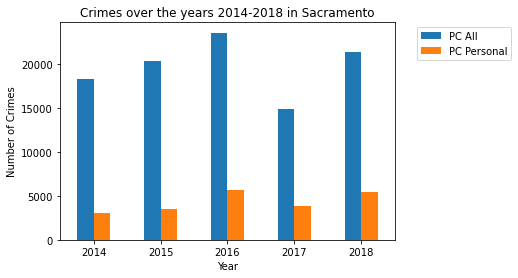

In [24]:
# Bar plot for all crimes and personal crimes over the years
clean_crime_min_df = pd.DataFrame()
clean_crime_min_df["PC All"] = clean_crime_df["PC"]
clean_crime_min_df["Year"] = clean_crime_df["Year"]
clean_crime_sum_group = clean_crime_min_df.groupby("Year").count()
clean_crime_personal_min_df = pd.DataFrame()
clean_crime_personal_min_df["PC Personal"] = clean_crime_personal_df["PC"]
clean_crime_personal_min_df["Year"] = clean_crime_personal_df["Year"]
clean_crime_personal_sum_group = clean_crime_personal_min_df.groupby("Year").count()
df = pd.merge(clean_crime_sum_group, clean_crime_personal_sum_group, on="Year")
df
df.plot.bar()
plt.title("Crimes over the years 2014-2018 in Sacramento")
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.xticks(rotation=0)
plt.savefig("./Images/CrimesBar2014-2018_pyplot.png")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()

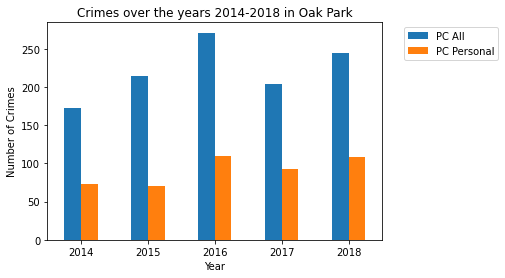

In [17]:
# Bar plot for all crimes and personal crimes in 95817 and 95820 over the years
clean_crime_oak_park_df = clean_crime_df.loc[(clean_crime_df["ZipCode"] == 95817) | (clean_crime_df["ZipCode"] == 95820)]
clean_crime_personal_oak_park_df = clean_crime_personal_df.loc[(clean_crime_personal_df["ZipCode"] == 95817) | (clean_crime_personal_df["ZipCode"] == 95820)]
clean_crime_min_df = pd.DataFrame()
clean_crime_min_df["PC All"] = clean_crime_oak_park_df["PC"]
clean_crime_min_df["Year"] = clean_crime_oak_park_df["Year"]
clean_crime_sum_group = clean_crime_min_df.groupby("Year").count()
# print(clean_crime_sum_group)
clean_crime_personal_min_df = pd.DataFrame()
clean_crime_personal_min_df["PC Personal"] = clean_crime_personal_oak_park_df["PC"]
clean_crime_personal_min_df["Year"] = clean_crime_personal_oak_park_df["Year"]
clean_crime_personal_sum_group = clean_crime_personal_min_df.groupby("Year").count()
df = pd.merge(clean_crime_sum_group, clean_crime_personal_sum_group, on="Year")
# df
df.plot.bar()
plt.title("Crimes over the years 2014-2018 in Oak Park")
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.xticks(rotation=0)
plt.savefig("./Images/CrimesBar2014-2018_Oak_Park_pyplot.png")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()